In [1]:
import sys
import os

# Add the path to your ML directory
sys.path.append(r'C:\Users\admin\Documents\Masters\ES_Masters\Masters-Processing\ML')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import optuna.visualization as vis
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import RFE
from mrmr_wrapper import MRMRTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import optuna
import optuna.visualization as vis
from sklearn.pipeline import Pipeline


# Import and Prepare Data

In [2]:
# Load the data
file_path = "../features-Master.csv"
data = pd.read_csv(file_path)

# Shuffle the data
shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
data_shuffled = shuffled.iloc[:, 4:]
labels_shuffled = shuffled["Comfort Score"]

# Train/Test Split

In [3]:
# For regression (using stratified split based on binned target)
X_train, X_test, y_train, y_test = train_test_split(
    data_shuffled, 
    labels_shuffled, 
    test_size=0.2, 
    stratify=labels_shuffled,
    random_state=42
)

# Optimize Feature Selection and Catboost Parameters

In [4]:
X = X_train.copy()
y = y_train.copy()

def objective(trial):
    # Feature selection, only optimizing method and number of features (no hyperparameters of the methods)
    fs_method = trial.suggest_categorical('feature_selection', ['RFE', 'MRMR', 'None'])

    if fs_method != 'None':
        k_features = trial.suggest_int('k_features', 5, 105, step = 10) 
        if fs_method == 'RFE':
            estimator = RandomForestRegressor()
            selector = RFE(estimator, n_features_to_select=k_features)
        else: #MRMR
            selector = MRMRTransformer(k_features=k_features) #https://feature-engine.trainindata.com/en/1.8.x/api_doc/selection/MRMR.html#feature_engine.selection.MRMR
    else:
        selector = 'passthrough'

    # CatBoost Hyperparameters
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000, step=25),
        'depth': trial.suggest_int('depth', 6, 10), #https://catboost.ai/docs/en/concepts/parameter-tuning
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True), #https://forecastegy.com/posts/catboost-hyperparameter-tuning-guide-with-optuna/
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True), 
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_seed': 42,
        'verbose': False,
    }
    model = CatBoostRegressor(**params)

    # 3. Pipeline 
    pipeline = Pipeline([
        ('feature_selection', selector),
        ('model', model)
    ])

    #4. Cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    try:
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2', n_jobs=1)
        return np.mean(scores)
    except Exception:
        return -np.inf

# Run Optuna Study
study = optuna.create_study(direction='maximize') # sampler = optuna.samplers.QMCSampler()) https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.QMCSampler.html#optuna.samplers.QMCSampler
study.optimize(objective, n_trials=5, show_progress_bar=True, n_jobs=6) 

# Best result
print("\n Regression Optimization Results")
print("===================================")
print(f"Best R²: {study.best_value:.4f}")
print("Best Parameters: ")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-09-16 12:22:36,388] A new study created in memory with name: no-name-4bb9aeb2-2513-4280-85e8-e6ef427b4416


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-09-16 12:23:01,383] Trial 0 finished with value: 0.13621691308647602 and parameters: {'feature_selection': 'None', 'iterations': 150, 'depth': 7, 'learning_rate': 0.005240407024248807, 'l2_leaf_reg': 0.19734300120787637, 'random_strength': 0.00022080890215117494, 'bagging_temperature': 0.4966424058647595, 'border_count': 56}. Best is trial 0 with value: 0.13621691308647602.






100%|██████████| 5/5 [00:00<00:00,  5.04it/s]




Got MRMR features









































100%|██████████| 55/55 [00:07<00:00,  7.56it/s]


Got MRMR features


100%|██████████| 5/5 [00:00<00:00,  7.23it/s]


Got MRMR features


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Got MRMR features


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


Got MRMR features


100%|██████████| 5/5 [00:00<00:00,  8.28it/s]


Got MRMR features
[I 2025-09-16 12:24:10,879] Trial 2 finished with value: 0.11286582778906154 and parameters: {'feature_selection': 'None', 'iterations': 100, 'depth': 9, 'learning_rate': 0.005783646489019062, 'l2_leaf_reg': 8.750424916009362e-05, 'random_strength': 1.6305623827716658e-08, 'bagging_temperature': 0.5505345806747839, 'border_count': 182}. Best is trial 0 with value: 0.13621691308647602.


[I 2025-09-16 12:24:12,592] Trial 1 finished with value: -0.0027739060714152995 and parameters: {'feature_selection': 'MRMR', 'k_features': 5, 'iterations': 550, 'depth': 10, 'learning_rate': 0.007333046655759052, 'l2_leaf_reg': 0.2949658817256709, 'random_strength': 8.73490636415516e-05, 'bagging_temperature': 0.34876861682604376, 'border_count': 53}. Best is trial 0 with value: 0.13621691308647602.


100%|██████████| 55/55 [00:02<00:00, 25.99it/s]


Got MRMR features


100%|██████████| 55/55 [00:02<00:00, 26.73it/s]


Got MRMR features


100%|██████████| 55/55 [00:02<00:00, 26.98it/s]


Got MRMR features


100%|██████████| 55/55 [00:02<00:00, 27.23it/s]


Got MRMR features
[I 2025-09-16 12:25:02,371] Trial 4 finished with value: 0.1669757341392915 and parameters: {'feature_selection': 'MRMR', 'k_features': 55, 'iterations': 925, 'depth': 10, 'learning_rate': 0.018123440730954923, 'l2_leaf_reg': 6.4476550779513e-05, 'random_strength': 2.2270340856717846e-09, 'bagging_temperature': 0.33311524914826907, 'border_count': 62}. Best is trial 4 with value: 0.1669757341392915.
[I 2025-09-16 12:58:51,530] Trial 3 finished with value: 0.1741462107206675 and parameters: {'feature_selection': 'RFE', 'k_features': 45, 'iterations': 750, 'depth': 6, 'learning_rate': 0.002722993330416217, 'l2_leaf_reg': 0.3214179559160425, 'random_strength': 0.020806579871067588, 'bagging_temperature': 0.4255817238514987, 'border_count': 158}. Best is trial 3 with value: 0.1741462107206675.

 Regression Optimization Results
Best R²: 0.1741
Best Parameters: 
  feature_selection: RFE
  k_features: 45
  iterations: 750
  depth: 6
  learning_rate: 0.002722993330416217
  l2

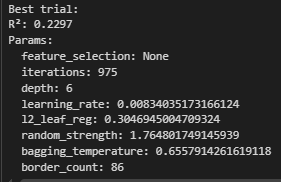
- 200 trials August 28, 2025

# Visualization

In [5]:
# 1. Parameter Importance Plot
fig = vis.plot_param_importances(study, target_name="R2 Score")
fig.show()

# 2. Slice Plot (Best for seeing individual parameter effects)
fig = vis.plot_slice(
    study,
    params=['depth','learning_rate','k_features'],
    target_name="R2 Score"
)
fig.show()

# Apply Feature Selection to Training & Test Data

In [6]:
# apply your feature selection code from before
best_fs_method = study.best_params.get('feature_selection', 'None')

if best_fs_method != 'None':
    k_features = study.best_params['k_features']
    if best_fs_method == 'RFE':
        estimator = RandomForestRegressor()
        selector = RFE(estimator, n_features_to_select=k_features,)
    else: #MRMR
        selector = MRMRTransformer(k_features=k_features)
    
    selector.fit(X, y)
    if hasattr(selector, 'get_support'):  # For SelectKBest/RFE
        selected_features = X.columns[selector.get_support()]
    else:  # For MRMR
        selected_features = selector.selected_features
    X_best = X[selected_features]
else:
    X_best = X
    selected_features = X.columns

# Apply the same feature selection to test data
if best_fs_method != 'None':
    if best_fs_method == 'MRMR':
        X_test_final = X_test[selected_features]
    else:
        X_test_final = selector.transform(X_test)  # Use the already fitted selector
        if isinstance(X_test, pd.DataFrame):
            X_test_final = pd.DataFrame(X_test_final, columns=selected_features)
else:
    X_test_final = X_test

# Create Catboost Model with Optimized Parameters and Fit Model

In [7]:
best_model = CatBoostRegressor(
    iterations=study.best_params['iterations'],
    depth=study.best_params['depth'],
    learning_rate=study.best_params['learning_rate'],
    l2_leaf_reg= study.best_params['l2_leaf_reg'],
    random_strength=study.best_params['random_strength'],
    bagging_temperature=study.best_params['bagging_temperature'],
    border_count=study.best_params['border_count'],
    random_seed = 42,
    verbose=False
)

# Train on full imputed data
best_model.fit(X_best, y, plot=True)
best_model.get_all_params()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 750,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 0.3214179575443268,
 'random_strength': 0.02080658078193665,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 158,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 

# Run Model and Get Outcomes

In [8]:
# Make predictions
y_pred = best_model.predict(X_test_final)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nFinal Model Evaluation on Test Set:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Calculate accuracy within ±1 point
correct = np.sum(np.abs(y_test - y_pred) <= 1)
accuracy = correct / len(y_test)
print(f"Accuracy within ±1 point: {accuracy:.4f}")


Final Model Evaluation on Test Set:
RMSE: 1.1964
R²: 0.1081
Accuracy within ±1 point: 0.5500
